In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jcm.geometry import get_coords
from jcm.model import Model
from jcm.physics.speedy.speedy_physics import SpeedyPhysics
from jcm.physics.speedy.params import Parameters
from jcm.boundaries import boundaries_from_file

def make_zeros_parameters_object(params):
    def make_tangent(x):
        if jnp.issubdtype(jnp.result_type(x), jnp.bool_):
            return np.zeros((), dtype=jax.dtypes.float0)
        elif jnp.issubdtype(jnp.result_type(x), jnp.integer):
            return np.zeros((), dtype=jax.dtypes.float0)
        else:
            return jnp.zeros_like(x)
    return jtu.tree_map(lambda x: make_tangent(x), params)

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

orography = jnp.load('../jcm/data/bc/t30/clim/orography.npy')
boundaries = boundaries_from_file('../jcm/data/bc/t30/clim/boundaries_daily.nc')

create_model = lambda params=Parameters.default(): Model(
    orography=orography,
    physics=SpeedyPhysics(parameters=params),
)

def model_run_wrapper(params):
    model = create_model(params)
    return model.run(save_interval=1/24., total_time=2./24., boundaries=boundaries)

# vjp

In [2]:
params = Parameters.default()
primal, vjp_fn = jax.vjp(model_run_wrapper, params)

In [ ]:
def create_cotangent(primal):
    cotangent = jtu.tree_map(jnp.zeros_like, primal)
    cotangent.physics.shortwave_rad.ftop = jtu.tree_map(jnp.ones_like, cotangent.physics.shortwave_rad.ftop)

    # coords = create_model(params).coords
    # nodal_ones = jnp.ones_like(coords.horizontal.to_nodal(primal.temperature_variation))
    # cotangent.temperature_variation = cotangent.temperature_variation.at[-1].add(coords.horizontal.to_modal(nodal_ones)[-1])
    return cotangent
grad = vjp_fn(create_cotangent(primal))

In [5]:
from pprint import pprint

def to_readable_format(x):
    if isinstance(x, jnp.ndarray):
        return x.tolist()
    return x

pprint(jax.tree_util.tree_map(to_readable_format, grad))

(Parameters(convection=ConvectionParameters(psmin=0.0,
                                            trcnv=0.0,
                                            rhil=0.0,
                                            rhbl=0.0,
                                            entmax=0.0,
                                            smf=0.0),
            condensation=CondensationParameters(trlsc=0.0,
                                                rhlsc=0.0,
                                                drhlsc=0.0,
                                                rhblsc=0.0),
            shortwave_radiation=ShortwaveRadiationParameters(albcl=-0.08723820745944977,
                                                             albcls=-1514915.0,
                                                             absdry=2989961.0,
                                                             absaer=892863.625,
                                                             abswv1=8754.052734375,
                     

# jvp

In [6]:
params = Parameters.default()
zero_params = make_zeros_parameters_object(params)
tangent = zero_params
# tangent.surface_flux.cds = jnp.array(1.)
# tangent.mod_radcon.emisfc = jnp.array(1.)
tangent.mod_radcon.albsea = jnp.array(1.)
y, jvp_at_x = jax.jvp(model_run_wrapper, (params,), (tangent,))

In [7]:
grad_ds = create_model(params).predictions_to_xarray(jvp_at_x)
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 11.8MB


In [8]:
print(list(grad_ds.variables))

['surface_flux.hfluxn.0', 'mod_radcon.tau2.2', 'shortwave_rad.ozupp', 'convection.se', 'land_model.stl_am', 'surface_flux.rlus.1', 'mod_radcon.alb_l', 'shortwave_rad.cloudc', 'temperature', 'mod_radcon.ablco2', 'surface_flux.t0', 'surface_flux.ustr.2', 'mod_radcon.stratc.1', 'surface_flux.rlus.0', 'surface_flux.tsfc', 'convection.precnv', 'shortwave_rad.stratz', 'surface_flux.v0', 'surface_flux.rlds', 'surface_flux.ustr.1', 'longwave_rad.dfabs', 'shortwave_rad.ftop', 'surface_flux.shf.0', 'convection.cbmf', 'mod_radcon.albsfc', 'shortwave_rad.dfabs', 'condensation.dtlsc', 'land_model.stl_lm', 'surface_flux.tskin', 'surface_flux.ustr.0', 'surface_flux.evap.1', 'mod_radcon.flux.1', 'mod_radcon.flux.2', 'shortwave_rad.zenit', 'shortwave_rad.gse', 'surface_flux.u0', 'surface_flux.evap.0', 'mod_radcon.flux.0', 'mod_radcon.st4a.0', 'shortwave_rad.fsol', 'mod_radcon.tau2.0', 'condensation.dqlsc', 'mod_radcon.st4a.1', 'divergence', 'u_dot_grad_log_sp', 'shortwave_rad.rsns', 'shortwave_rad.ozon

gradient of shortwave_rad.ozupp is 0.0
gradient of land_model.stl_am is 0.0
gradient of surface_flux.rlus.1 is 0.0
gradient of mod_radcon.alb_l is 0.0
gradient of shortwave_rad.cloudc is 0.0
gradient of surface_flux.tsfc is 0.0
gradient of convection.precnv is 0.0
gradient of shortwave_rad.stratz is 0.0
gradient of convection.cbmf is 0.0
gradient of condensation.dtlsc is 0.0
gradient of land_model.stl_lm is 0.0


/home/jvm/miniconda3/envs/jax-dev-cuda/lib/python3.11/site-packages/xarray/plot/utils.py:479: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kws)


gradient of shortwave_rad.zenit is 0.0
gradient of shortwave_rad.fsol is 0.0
gradient of condensation.dqlsc is 0.0
gradient of shortwave_rad.ozone is 0.0
gradient of mod_radcon.alb_s is 1.0
gradient of mod_radcon.snowc is -0.0
gradient of condensation.precls is -0.0


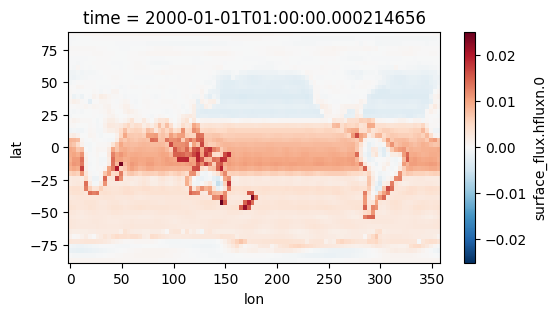

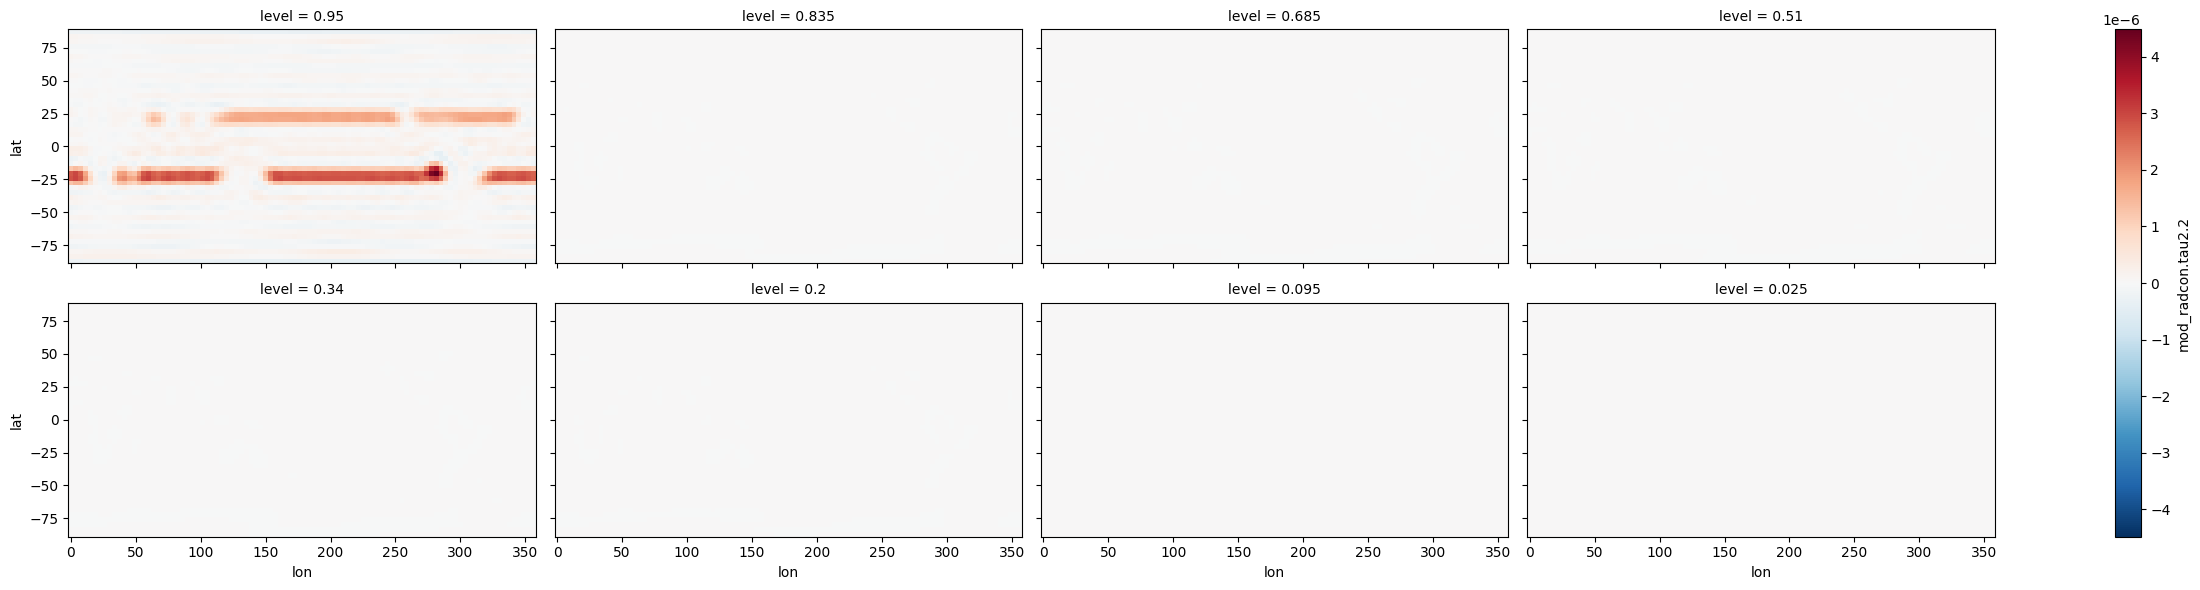

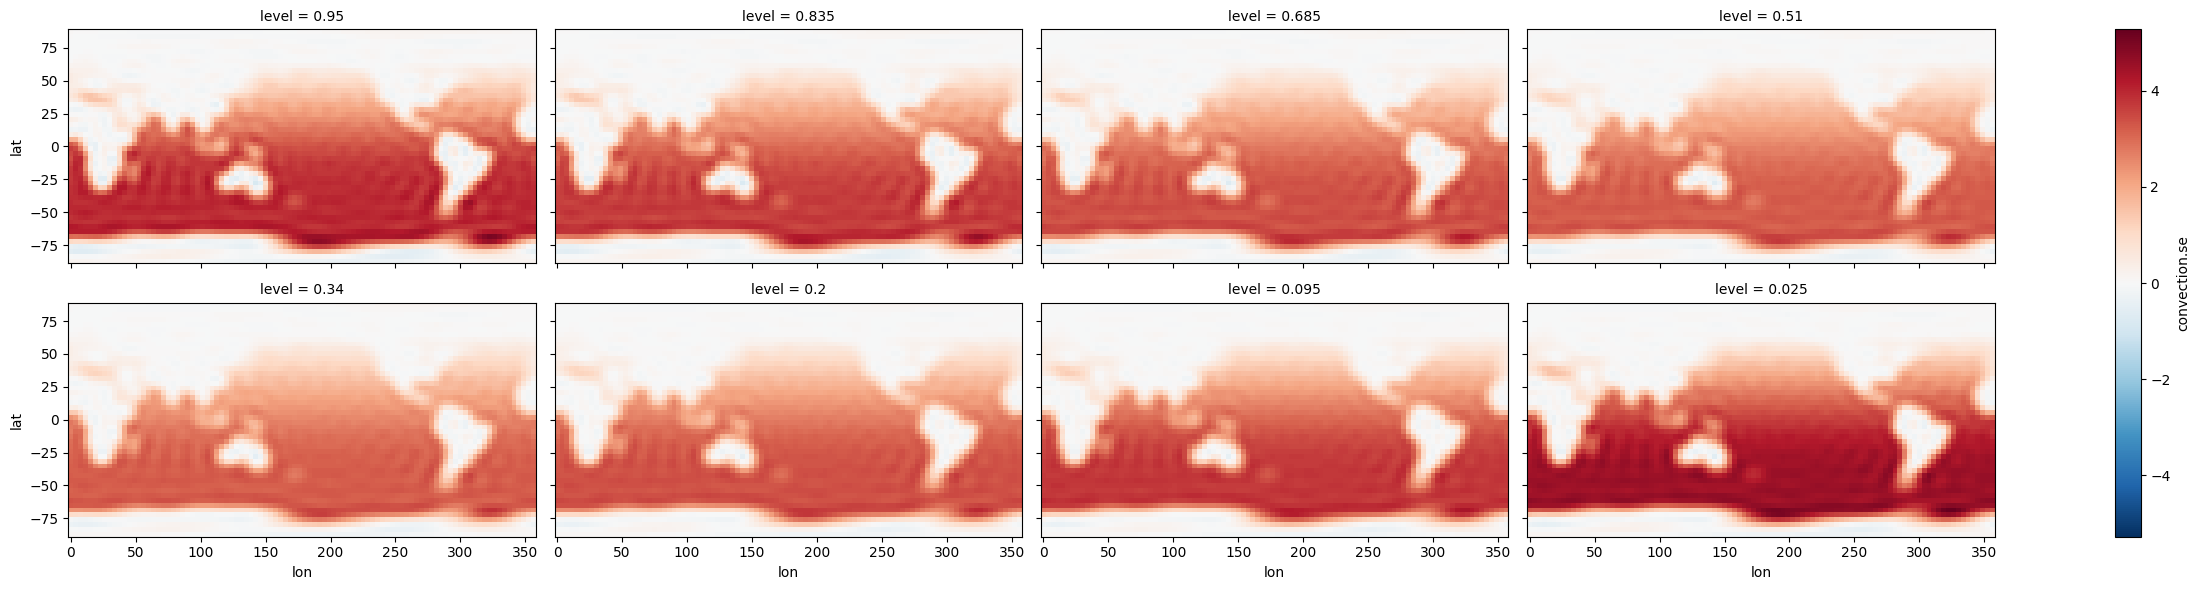

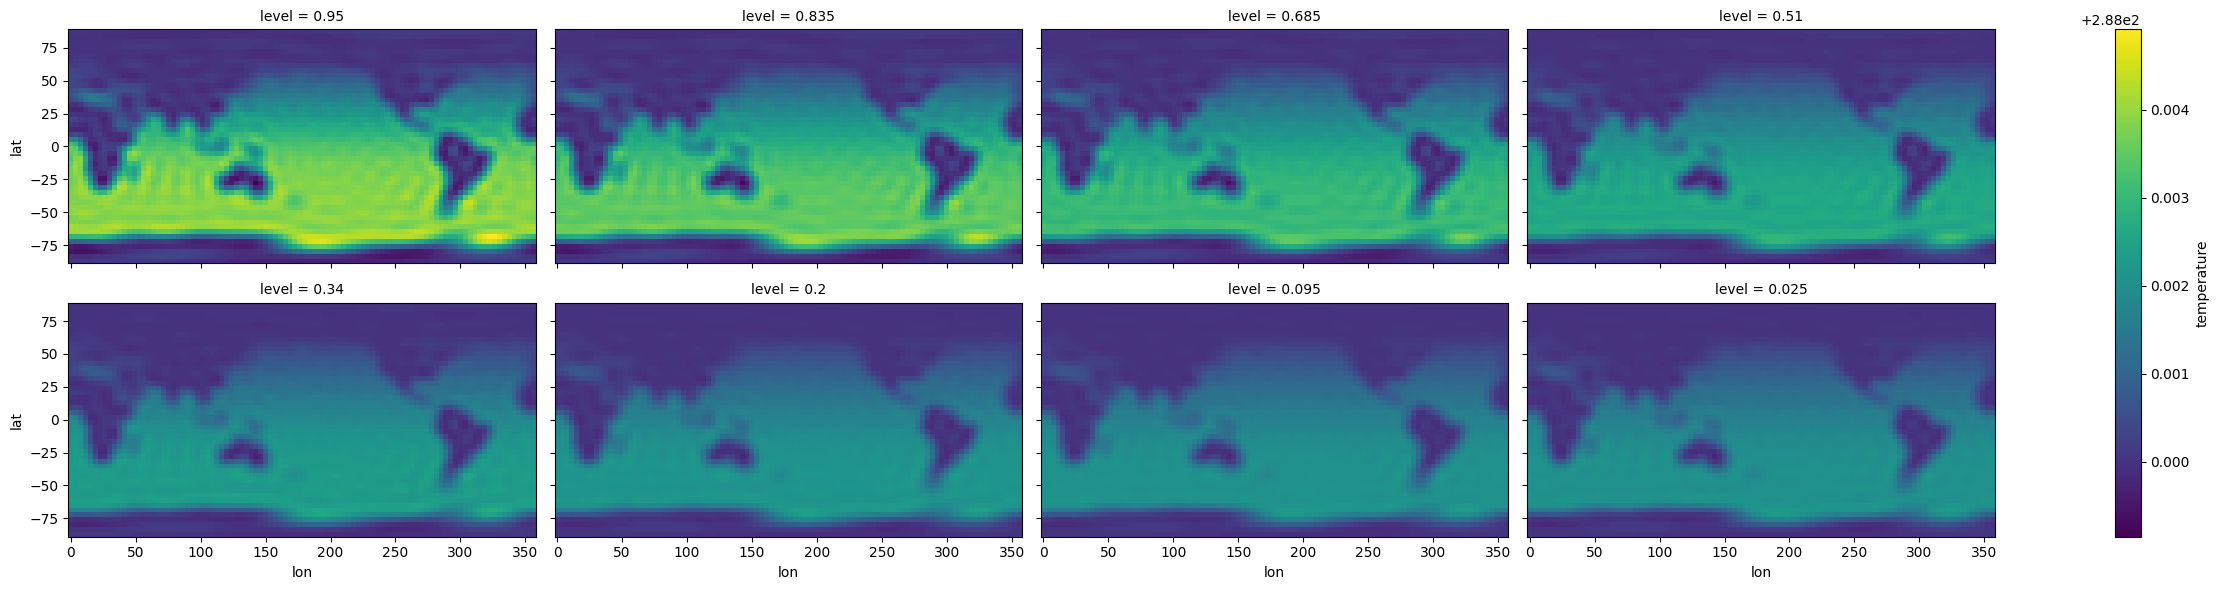

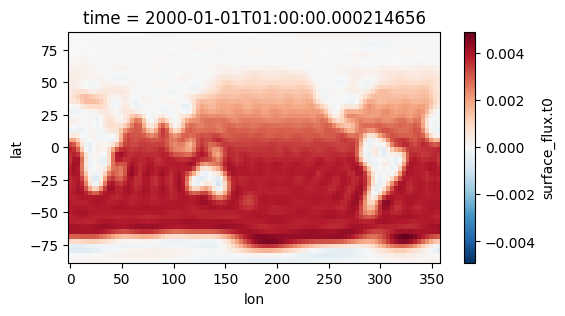

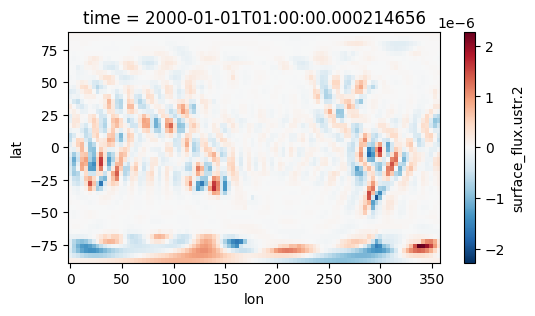

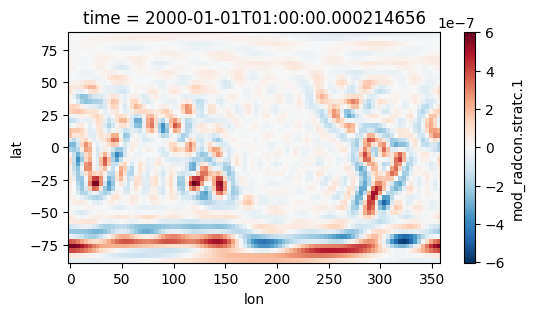

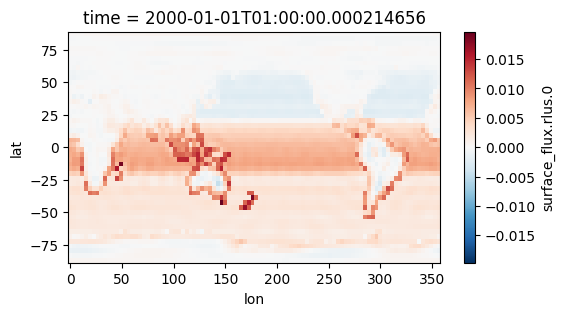

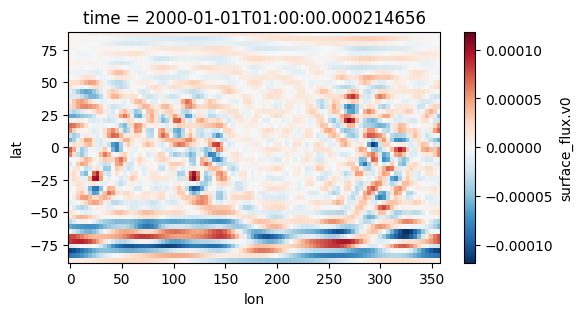

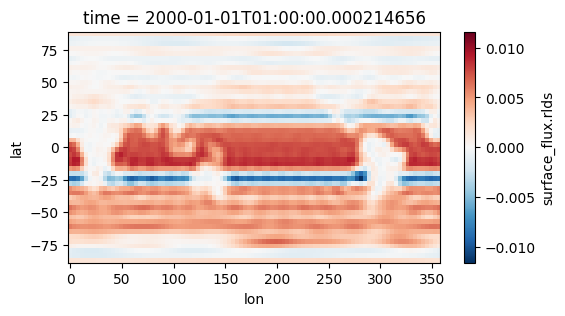

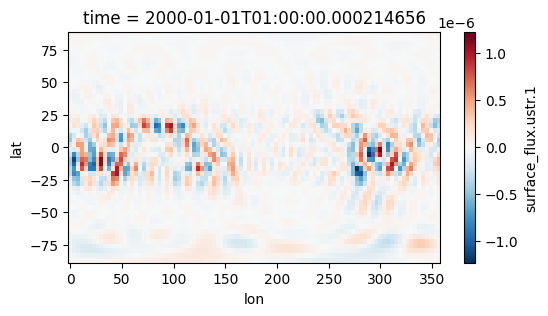

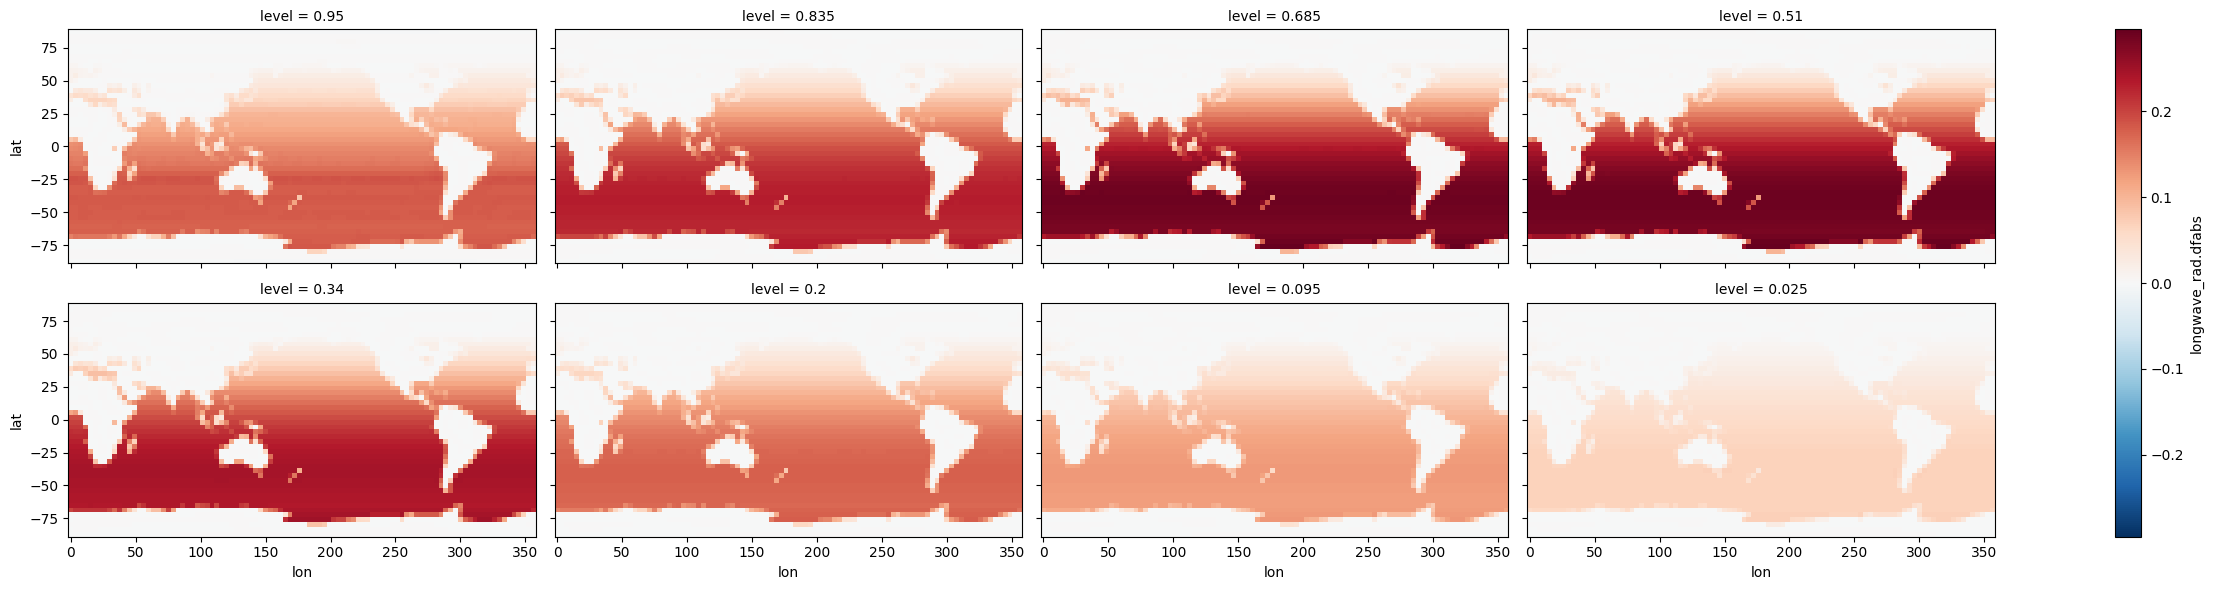

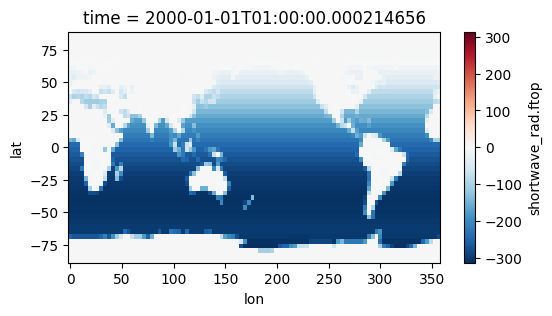

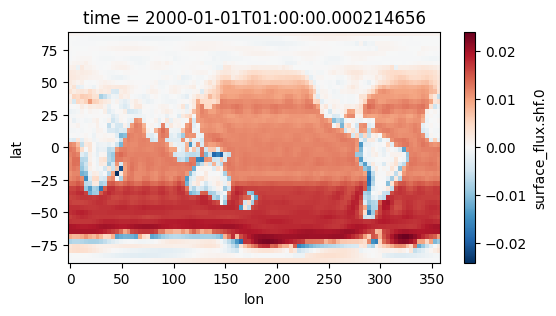

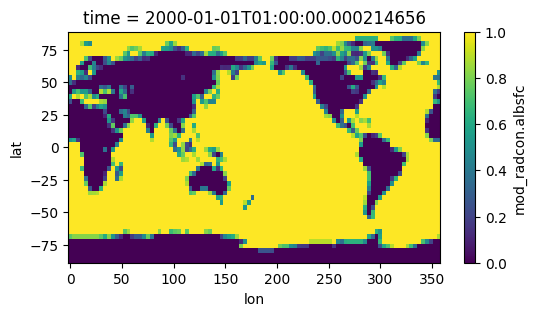

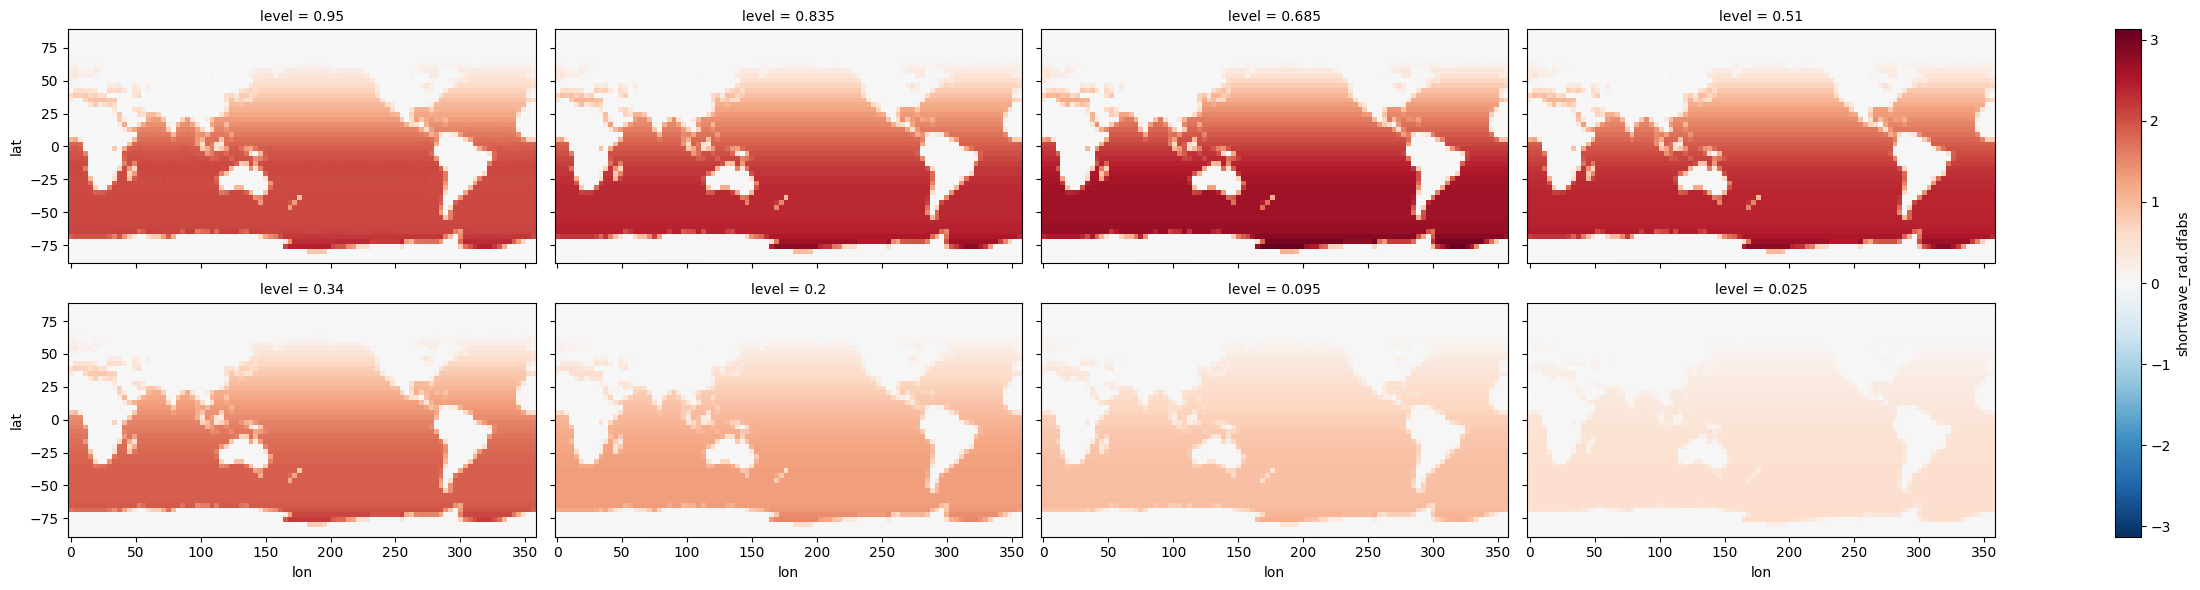

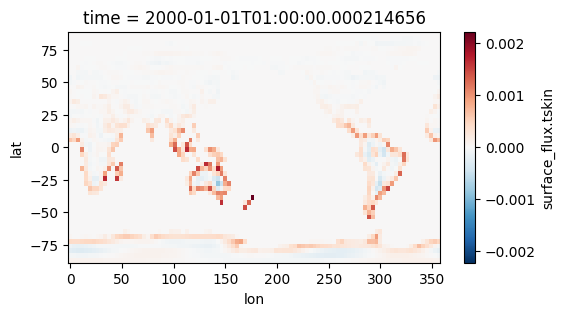

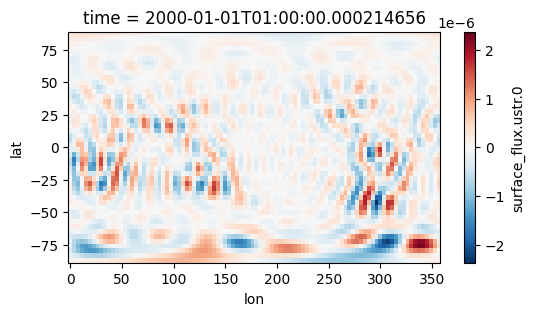

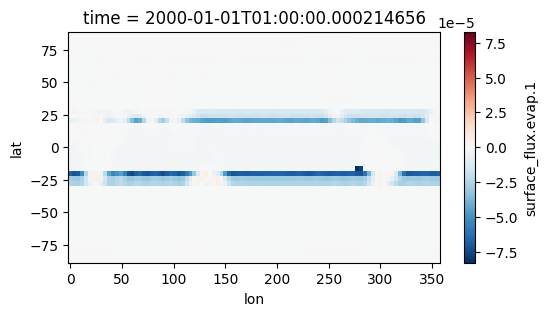

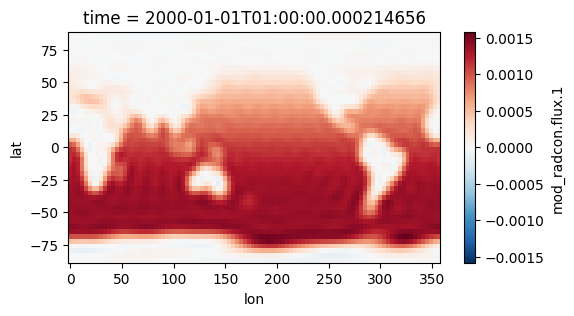

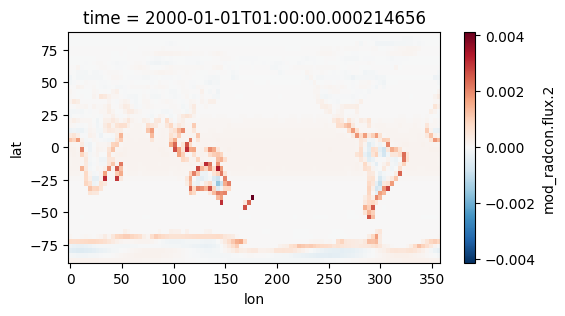

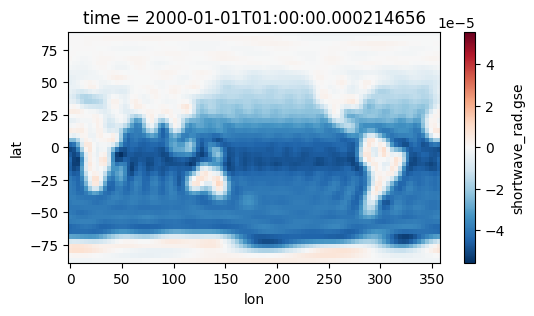

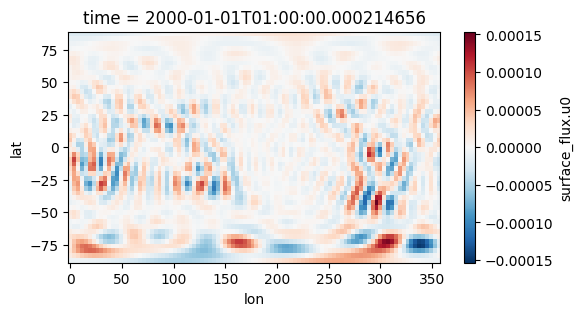

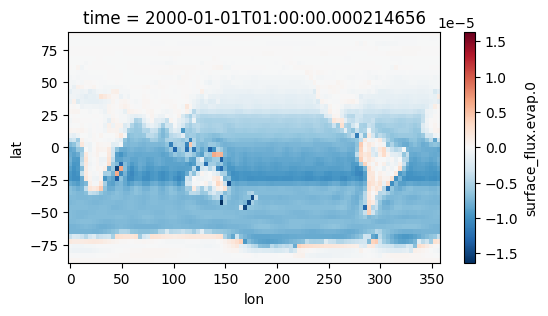

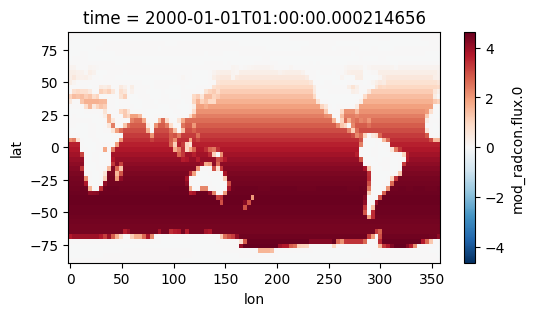

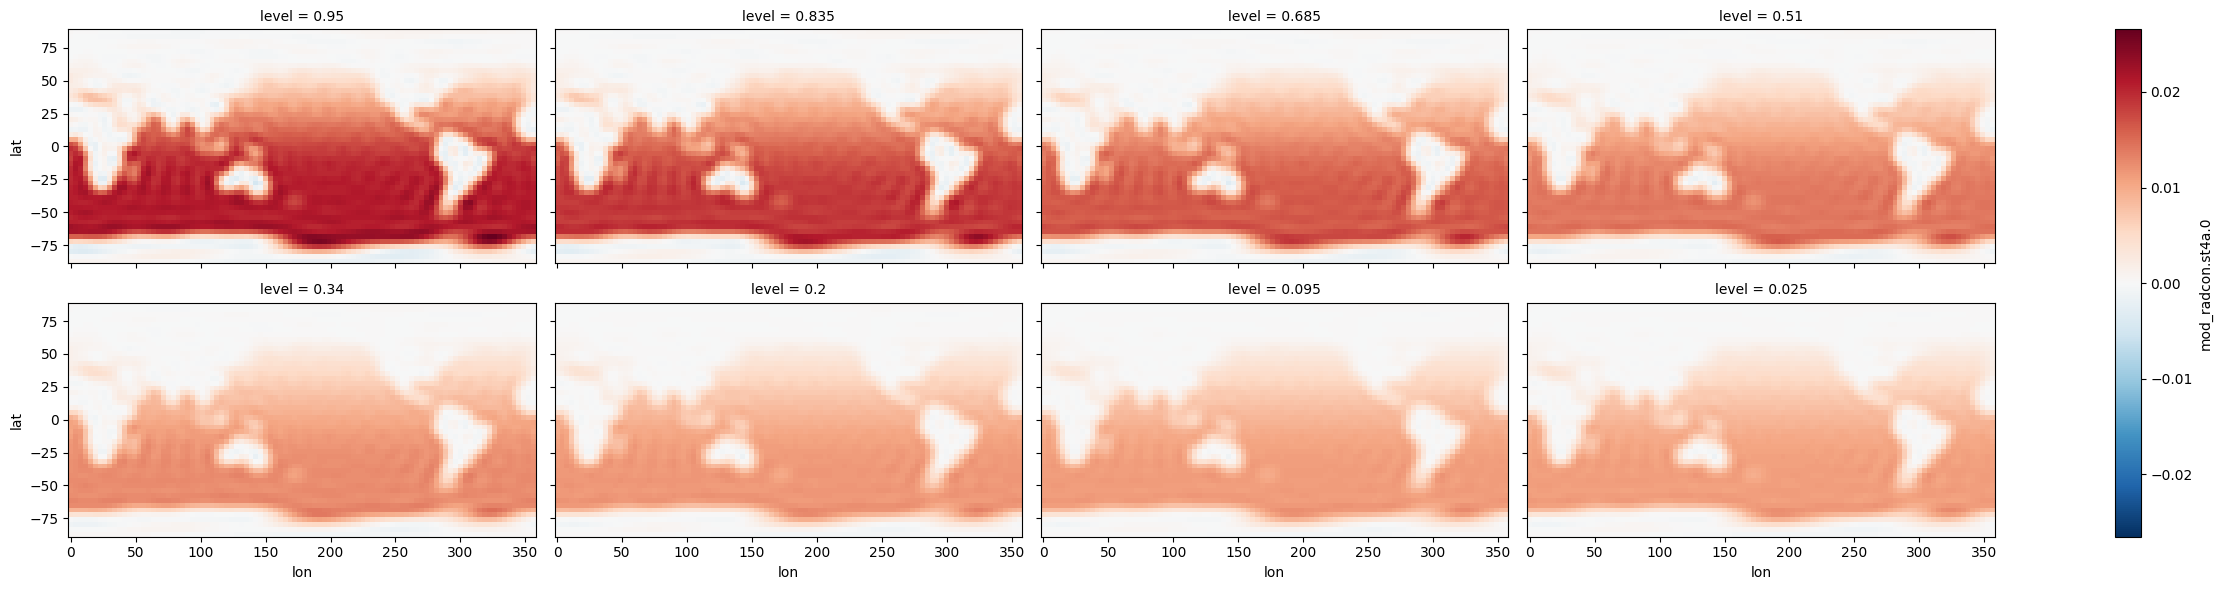

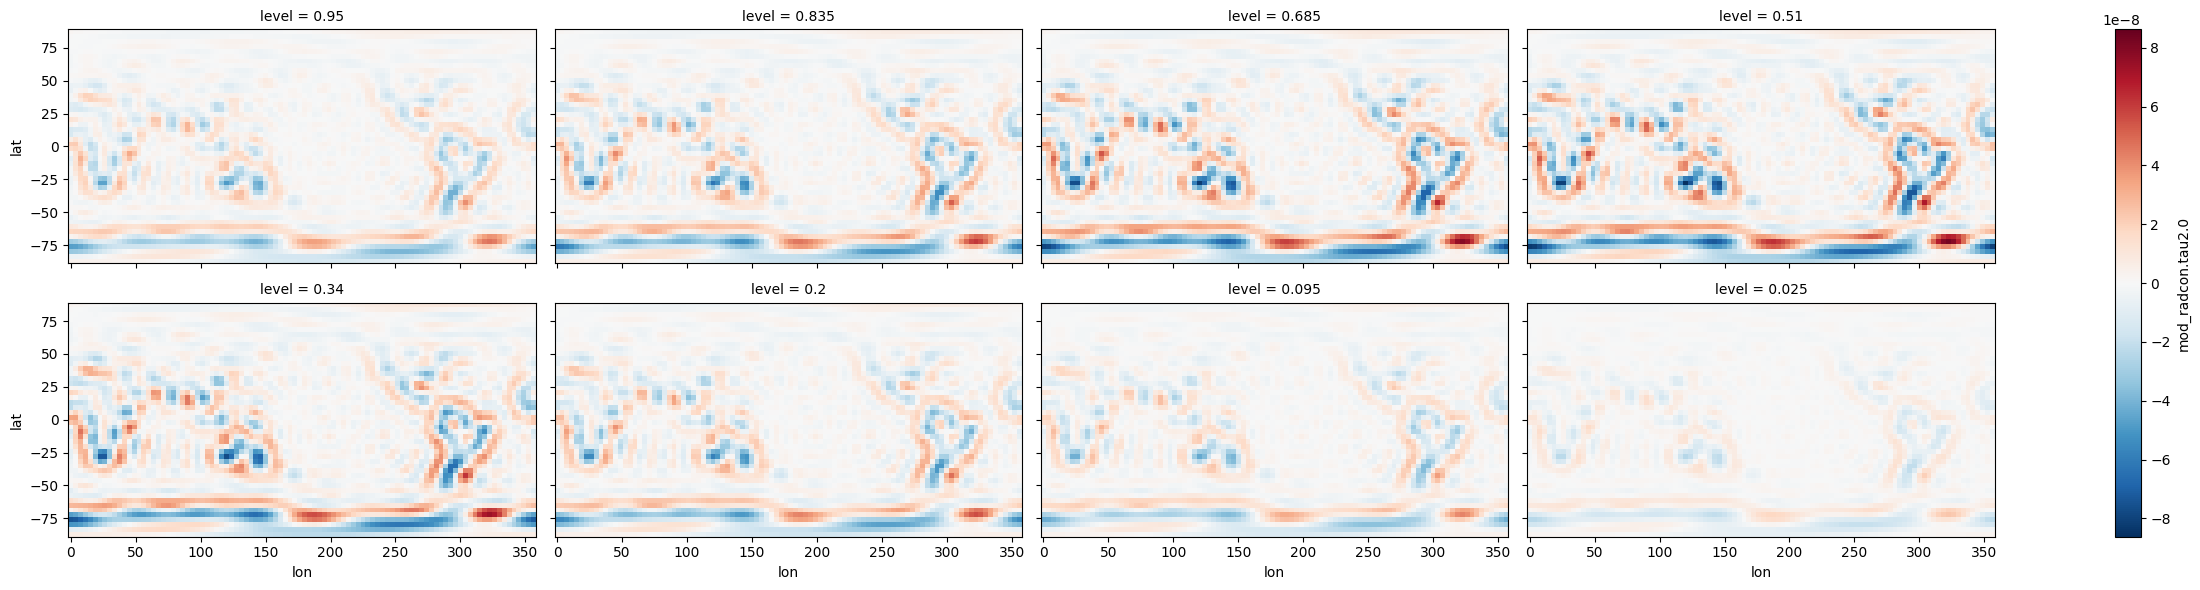

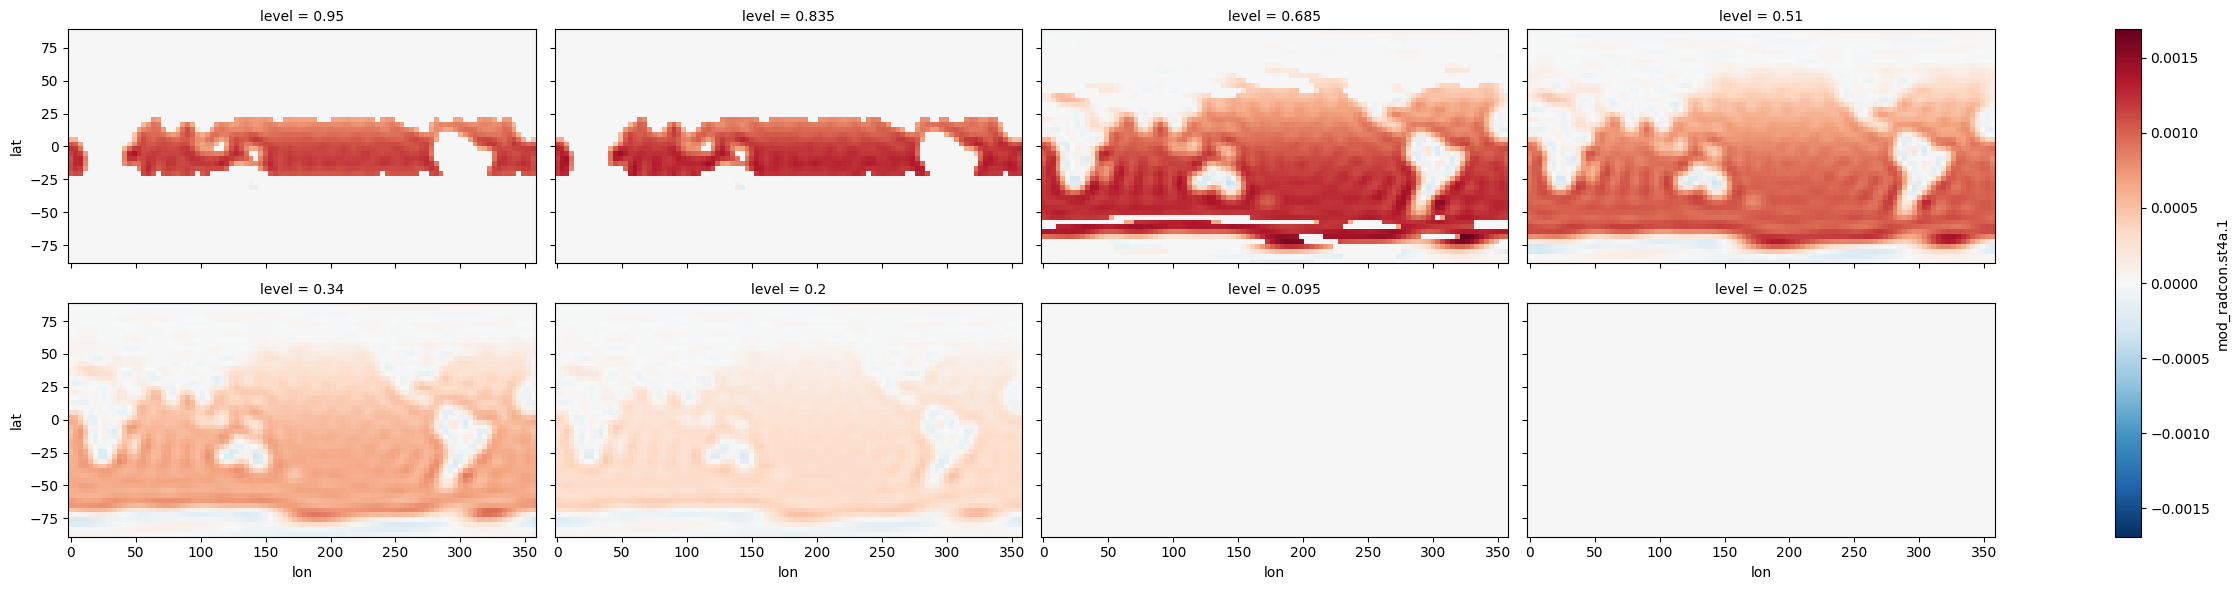

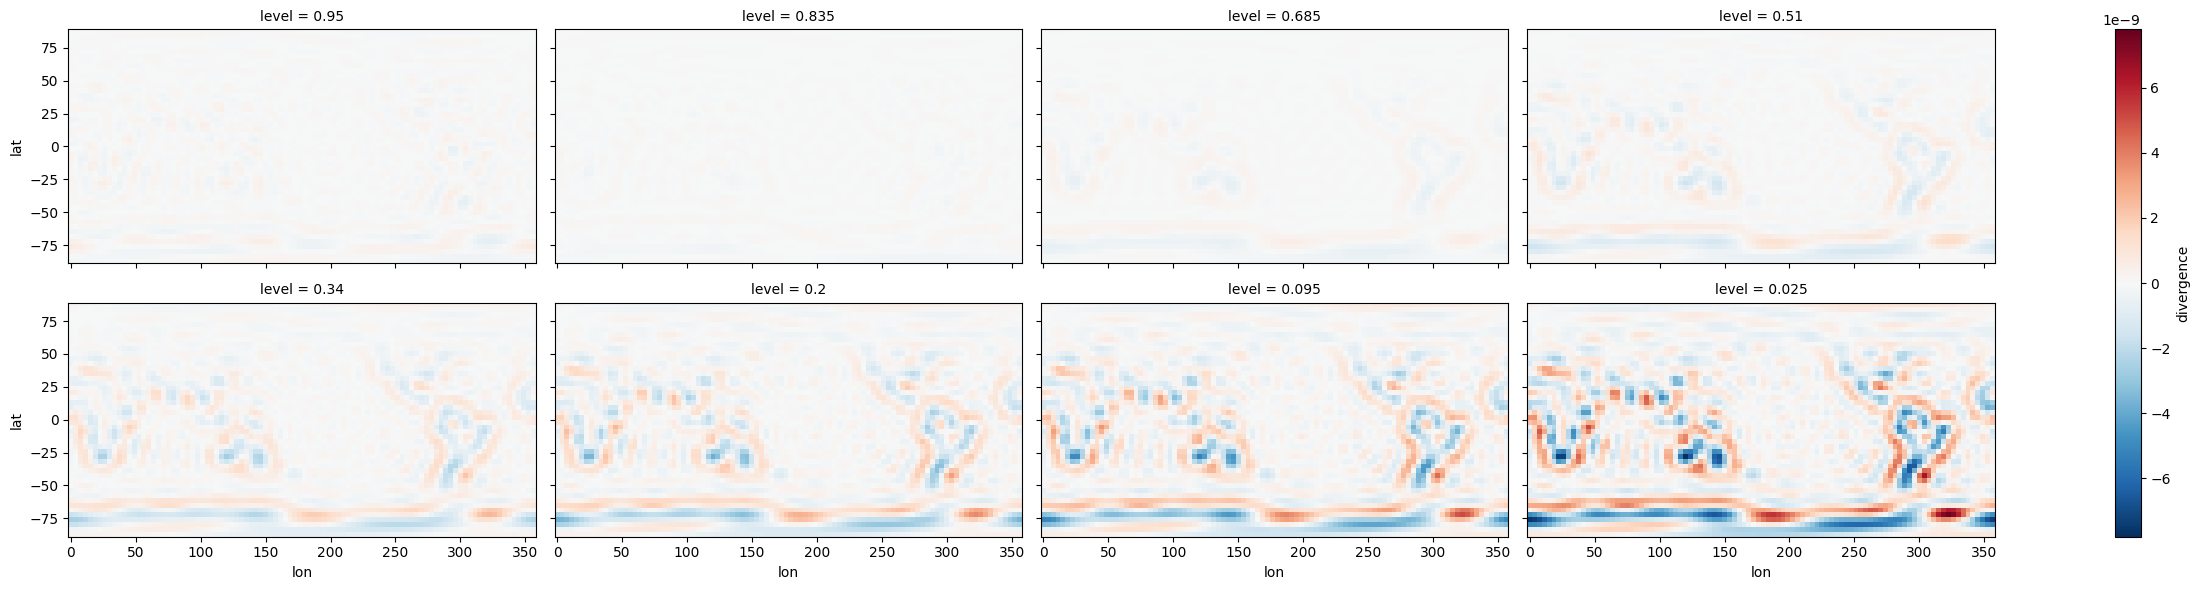

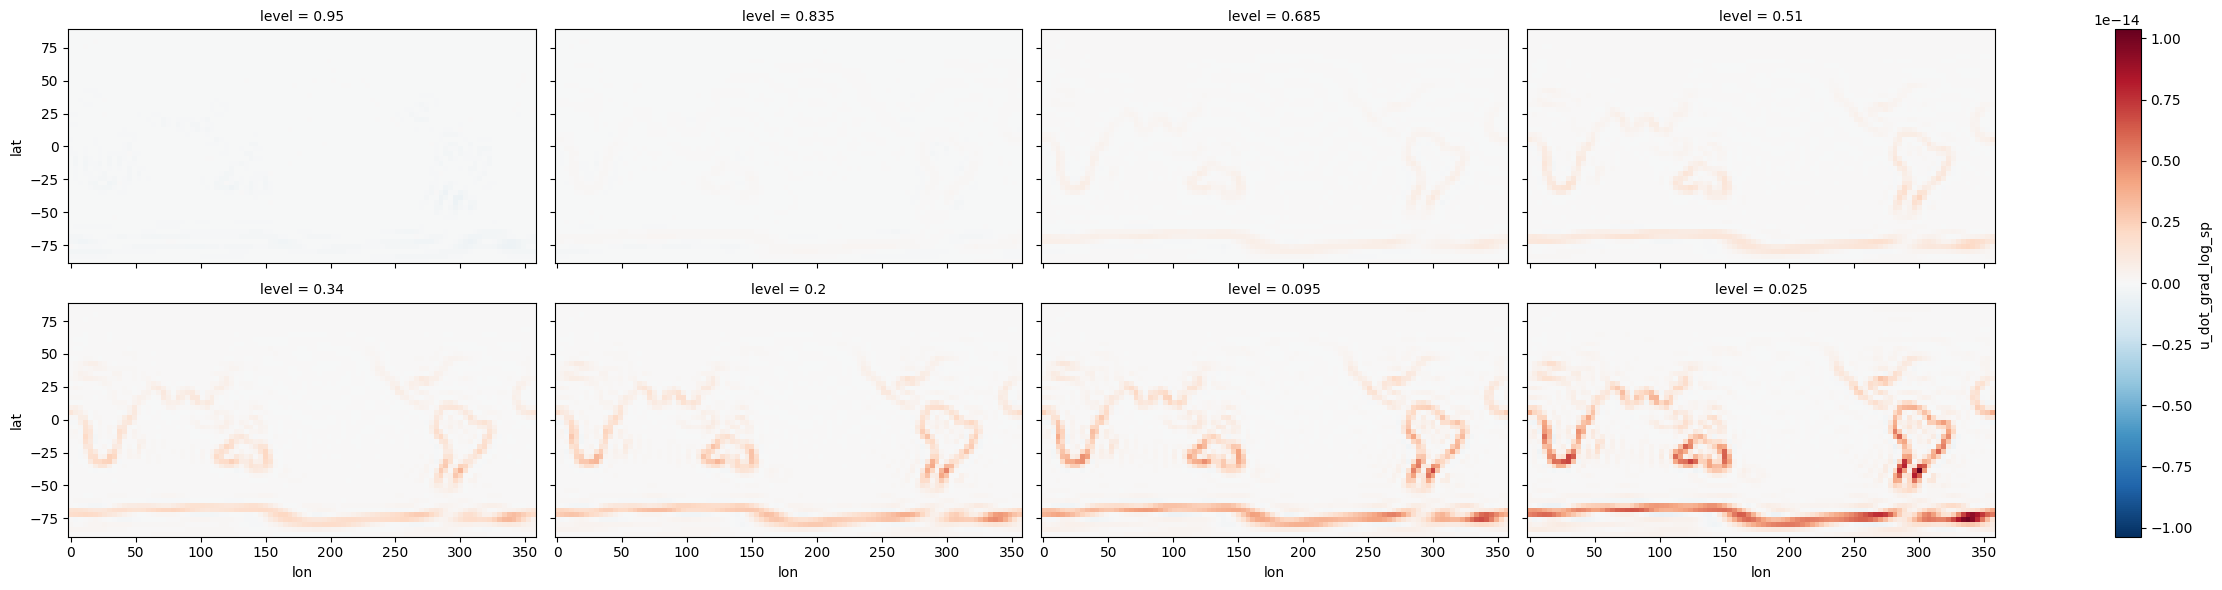

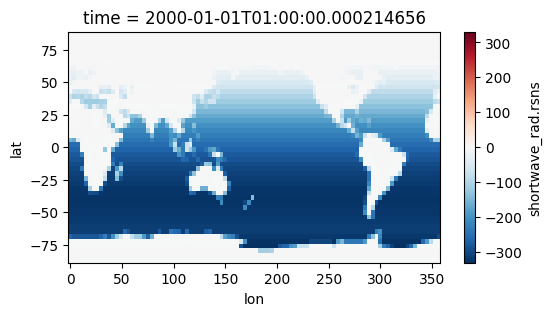

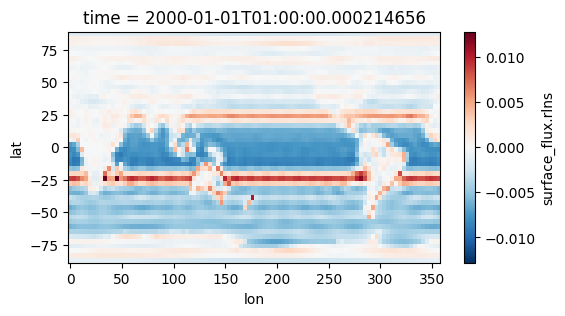

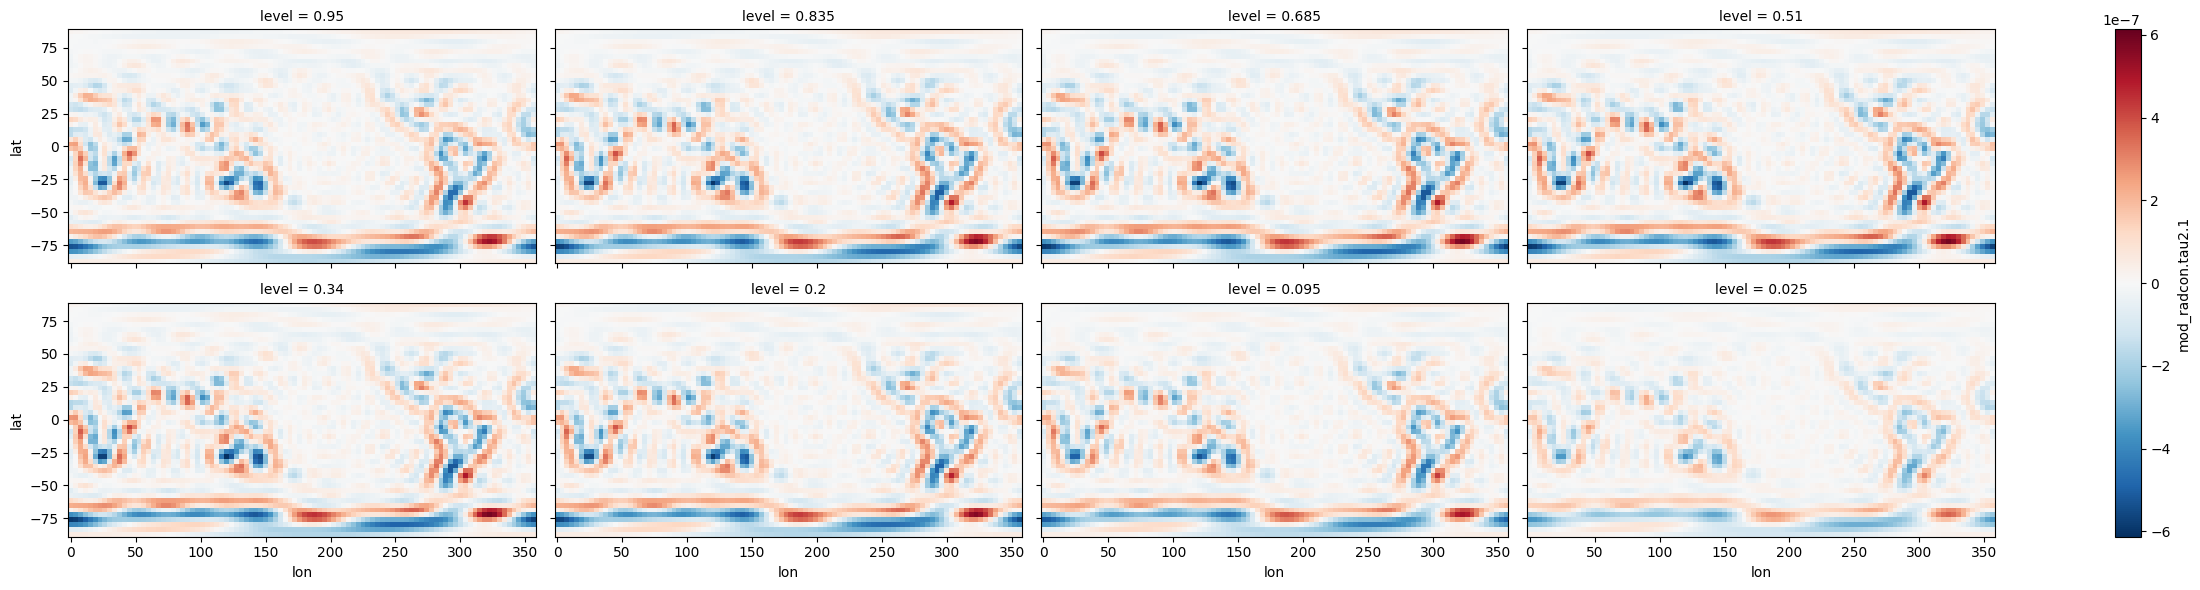

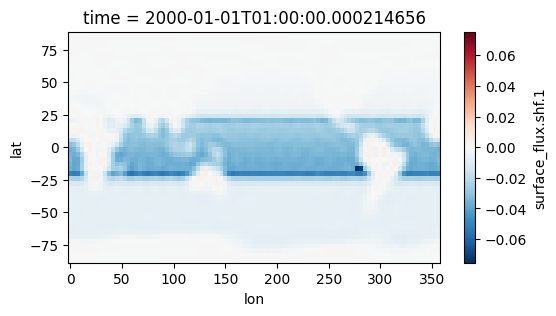

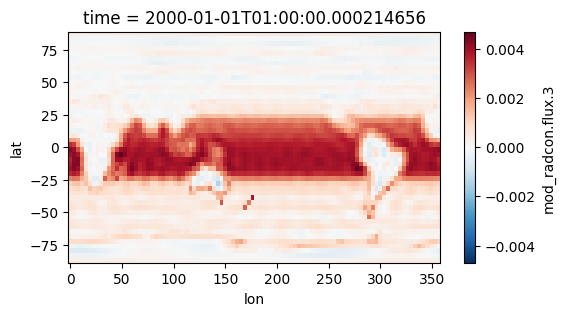

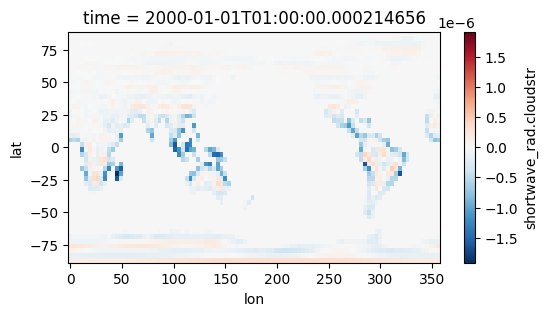

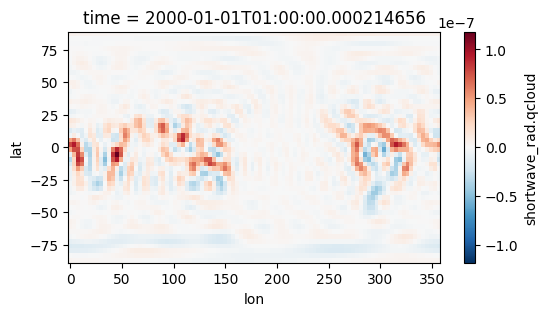

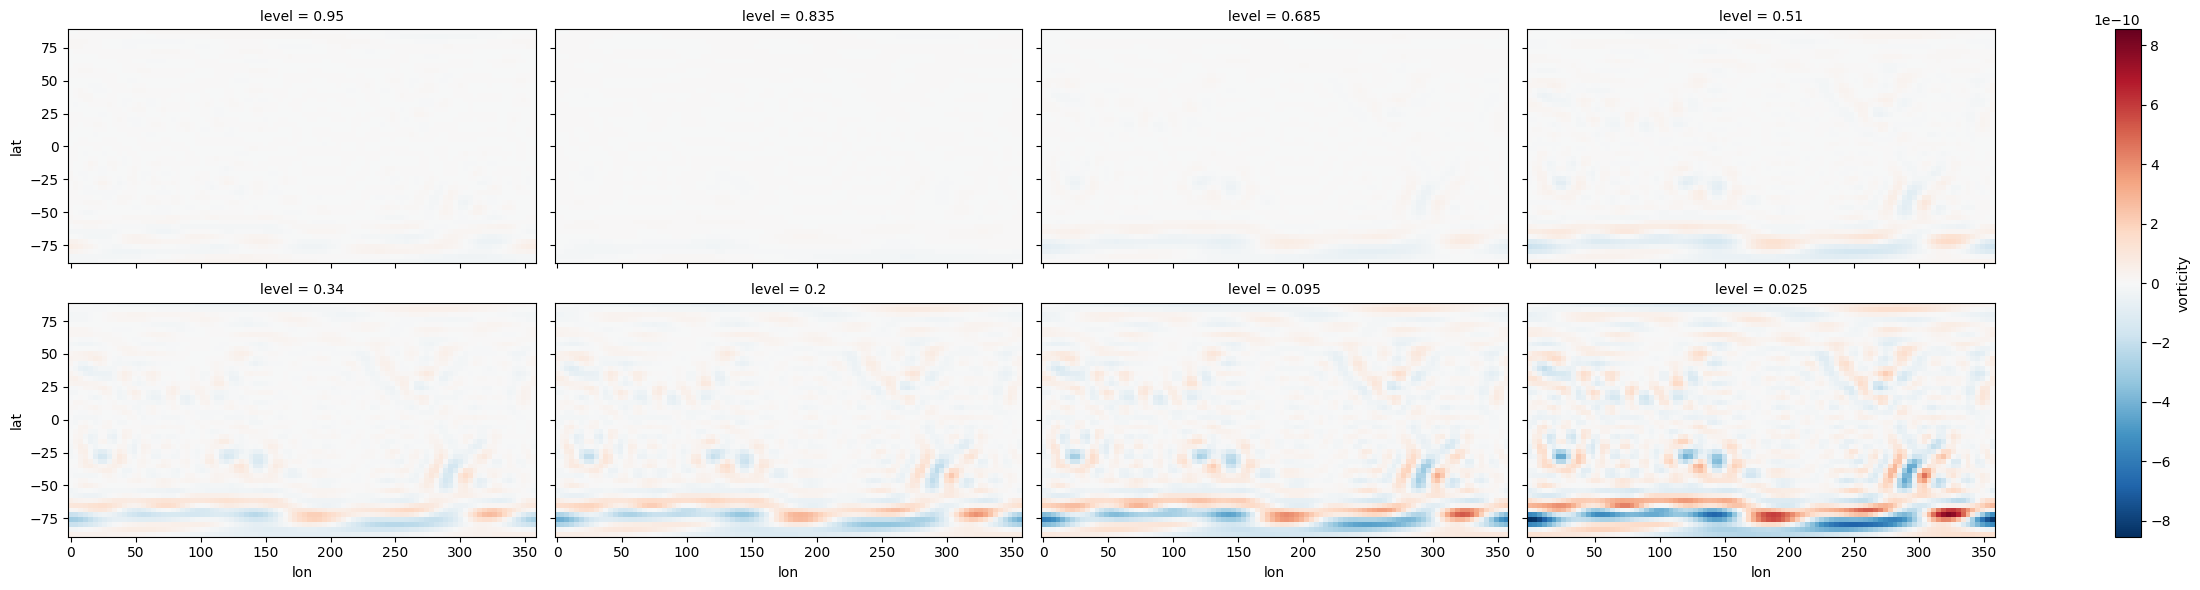

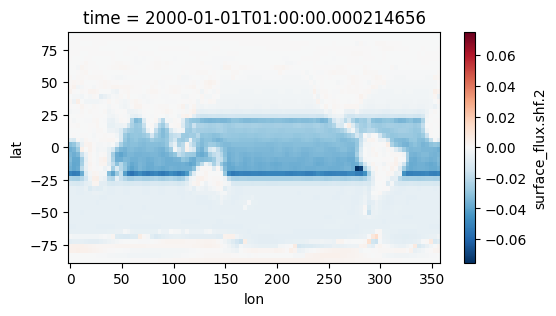

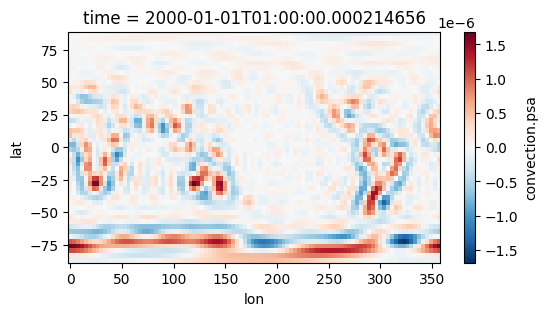

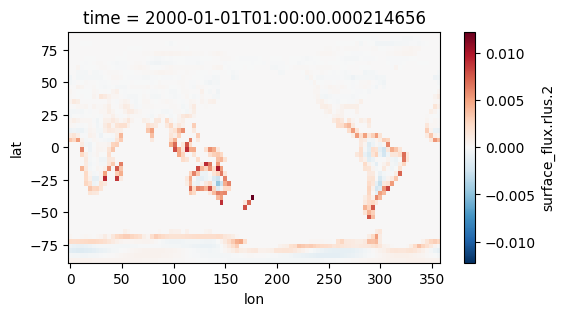

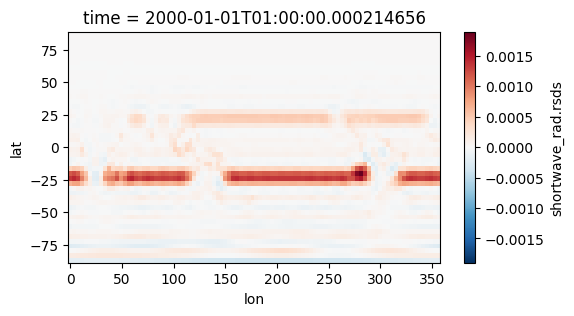

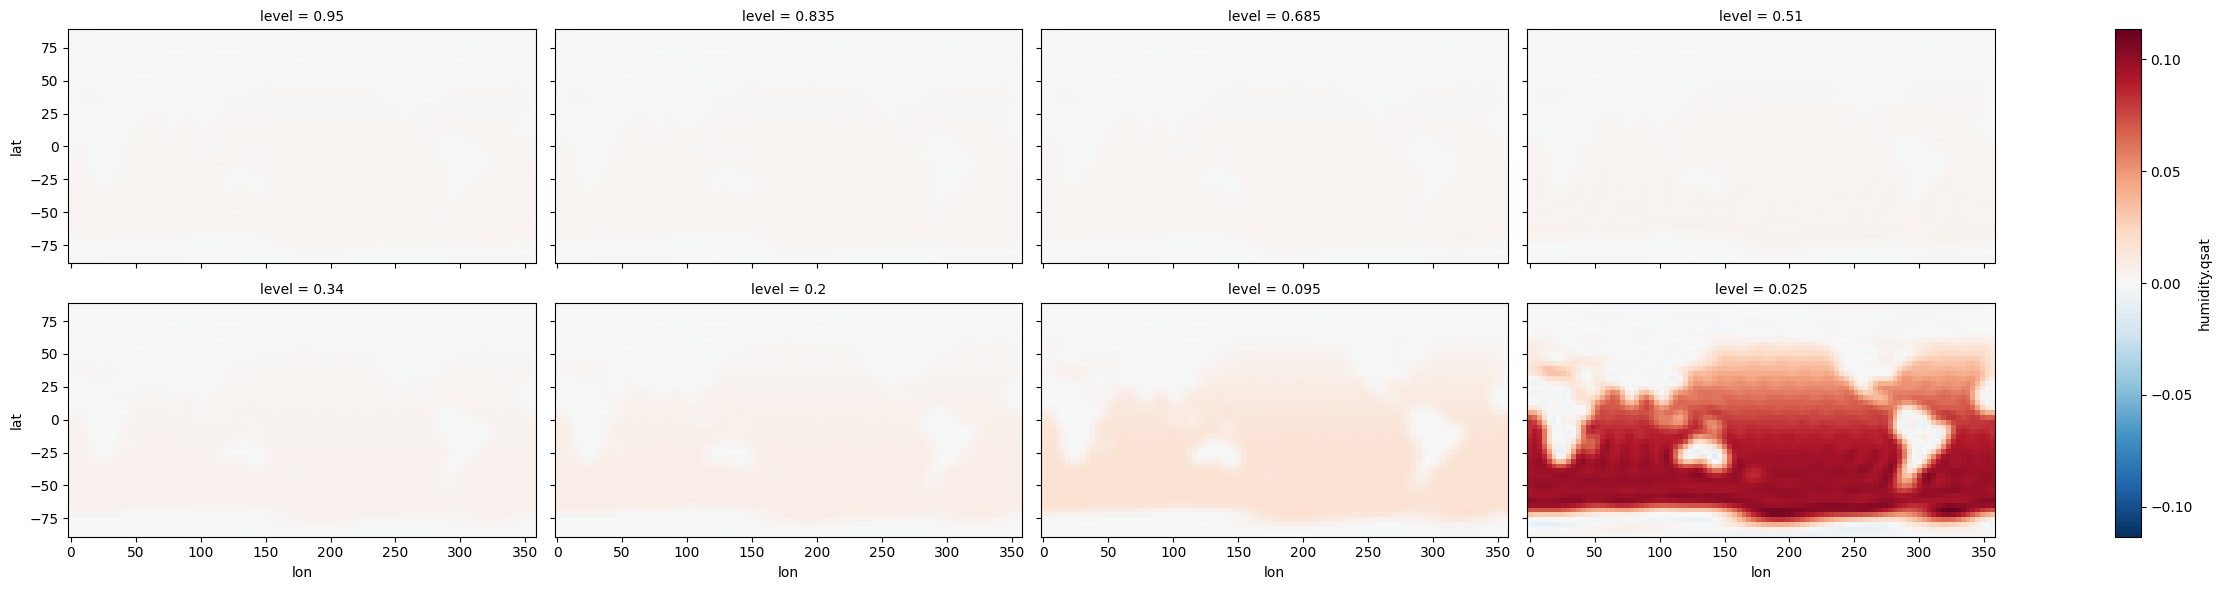

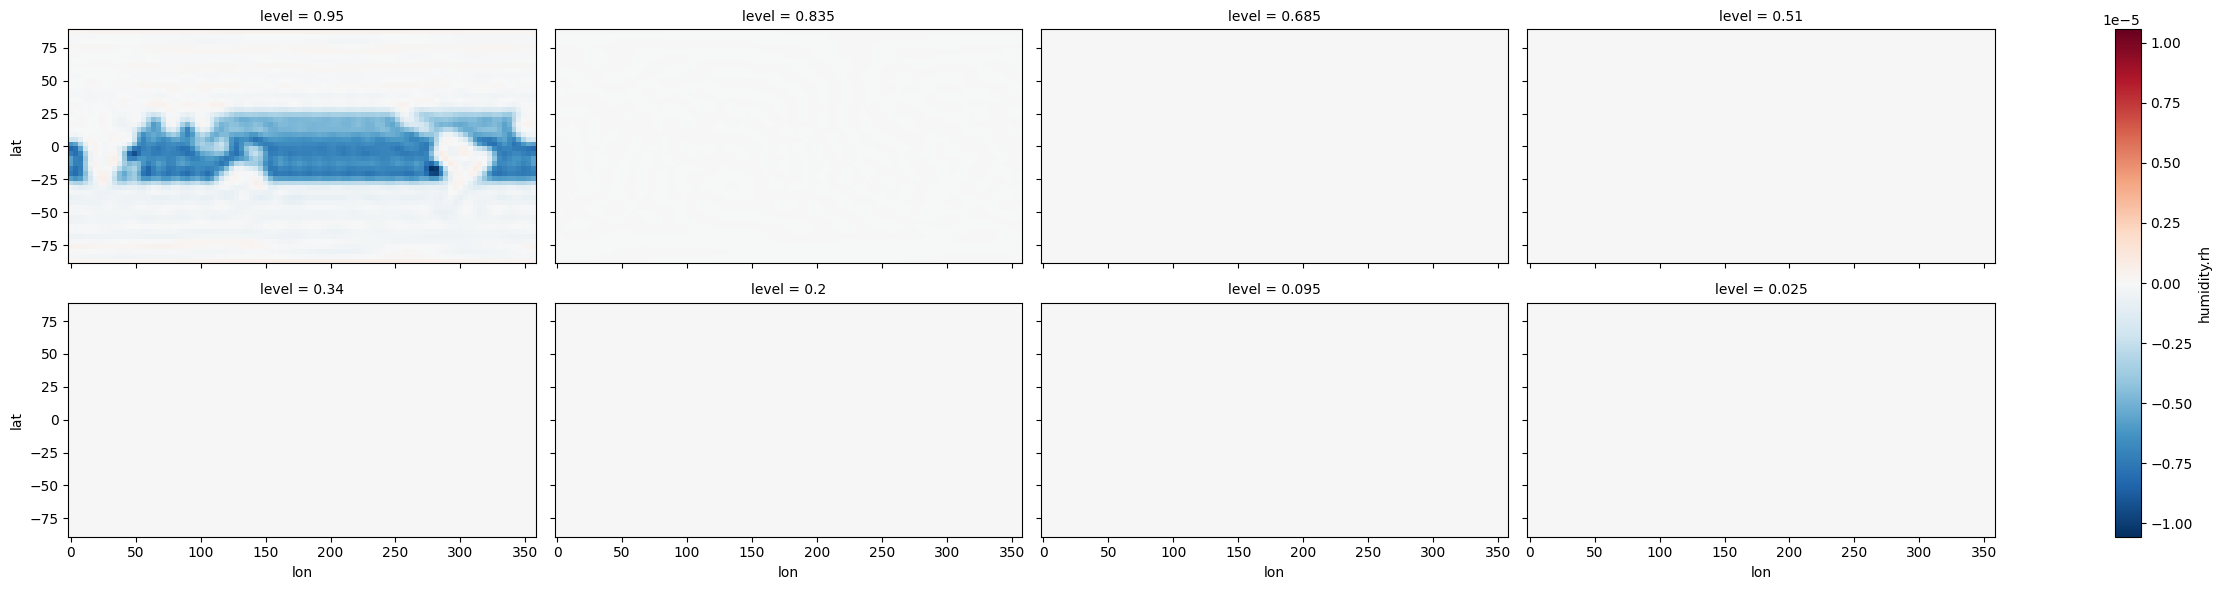

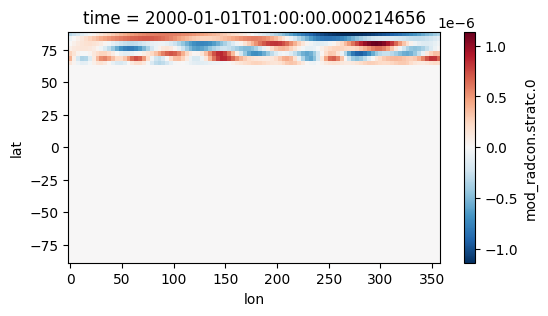

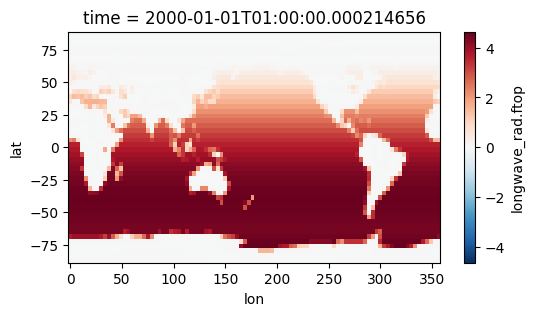

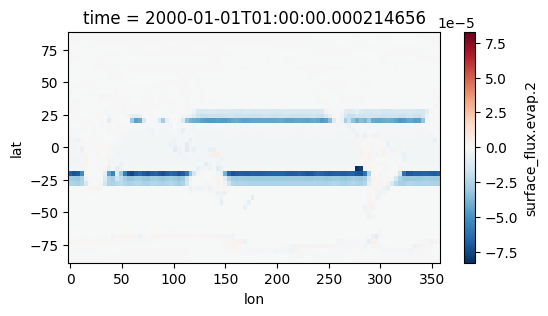

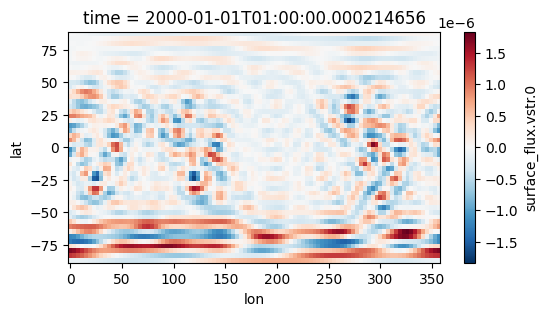

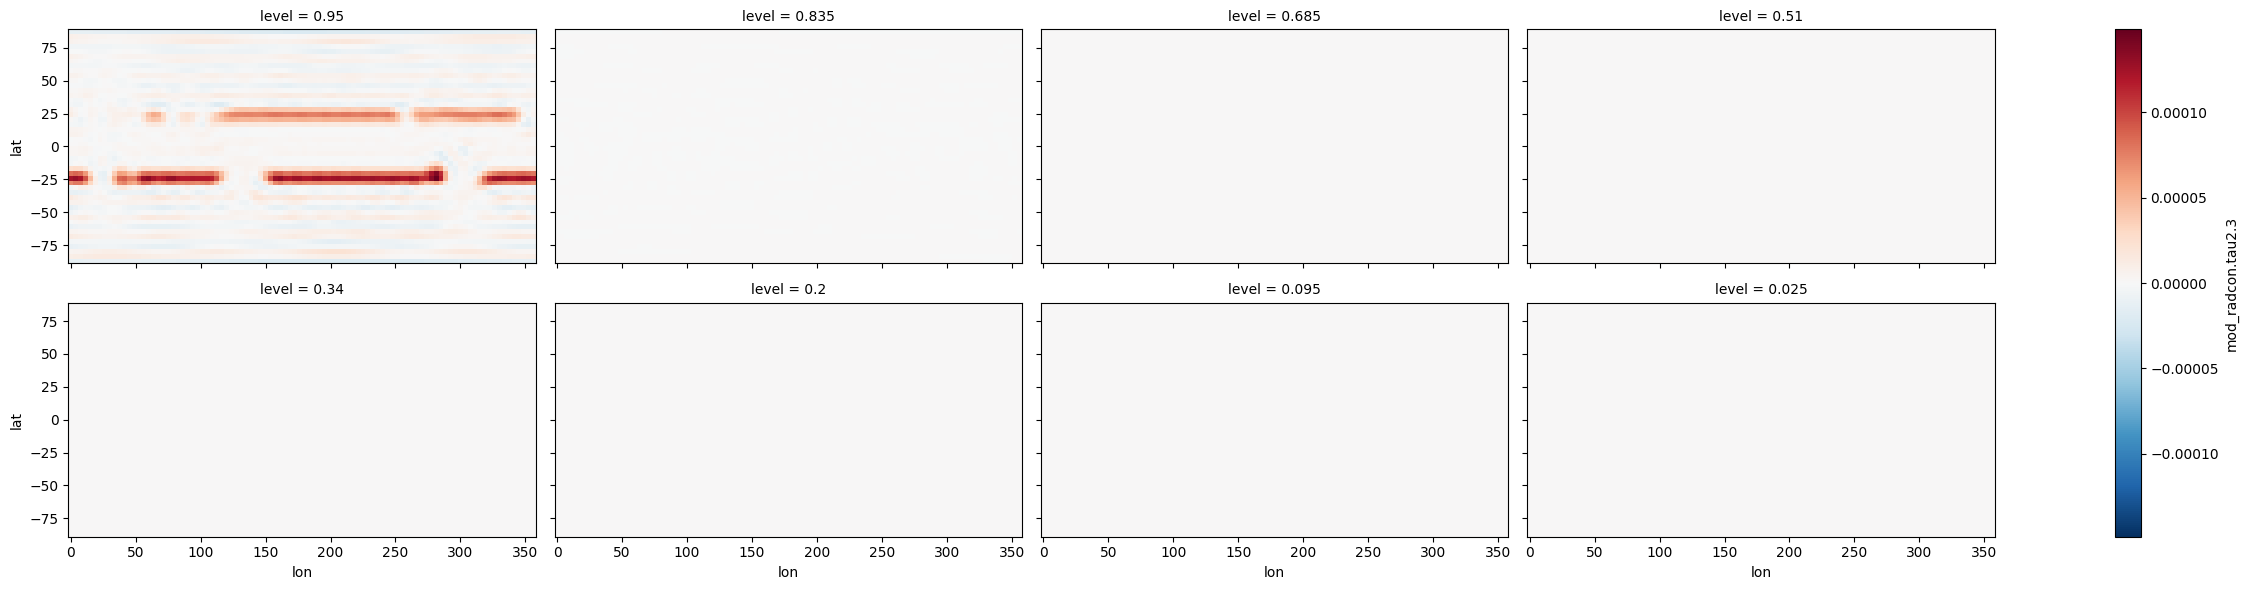

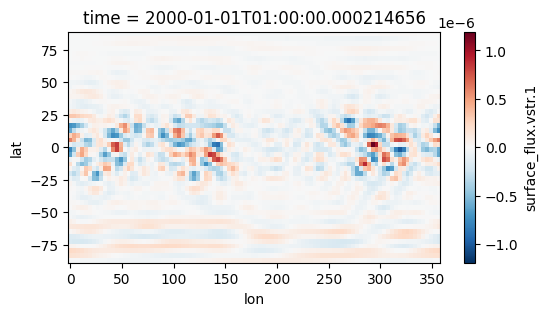

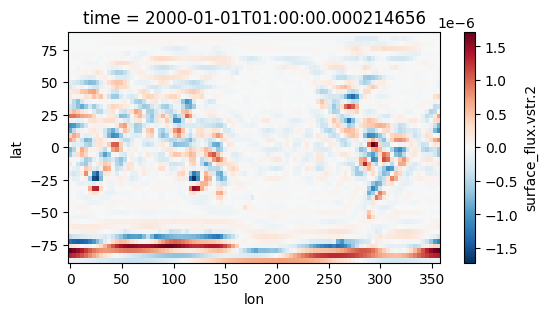

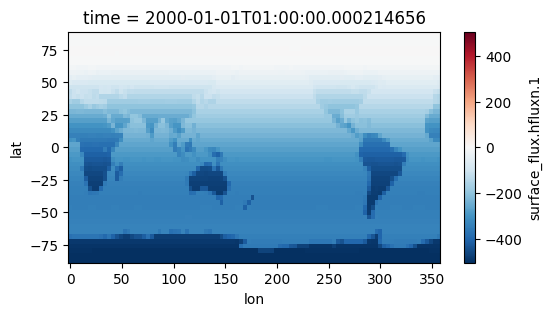

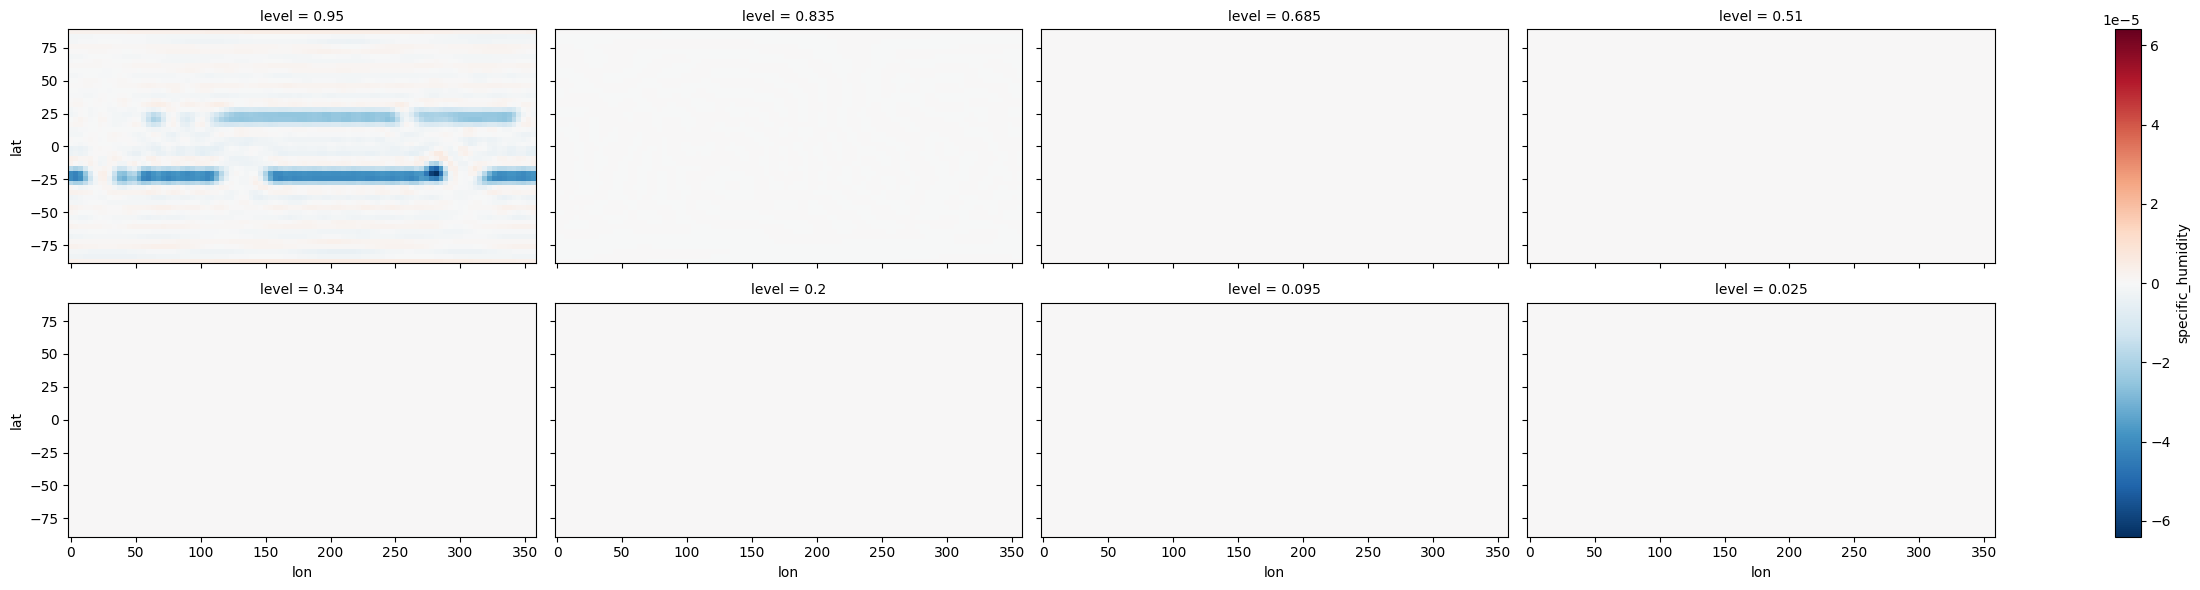

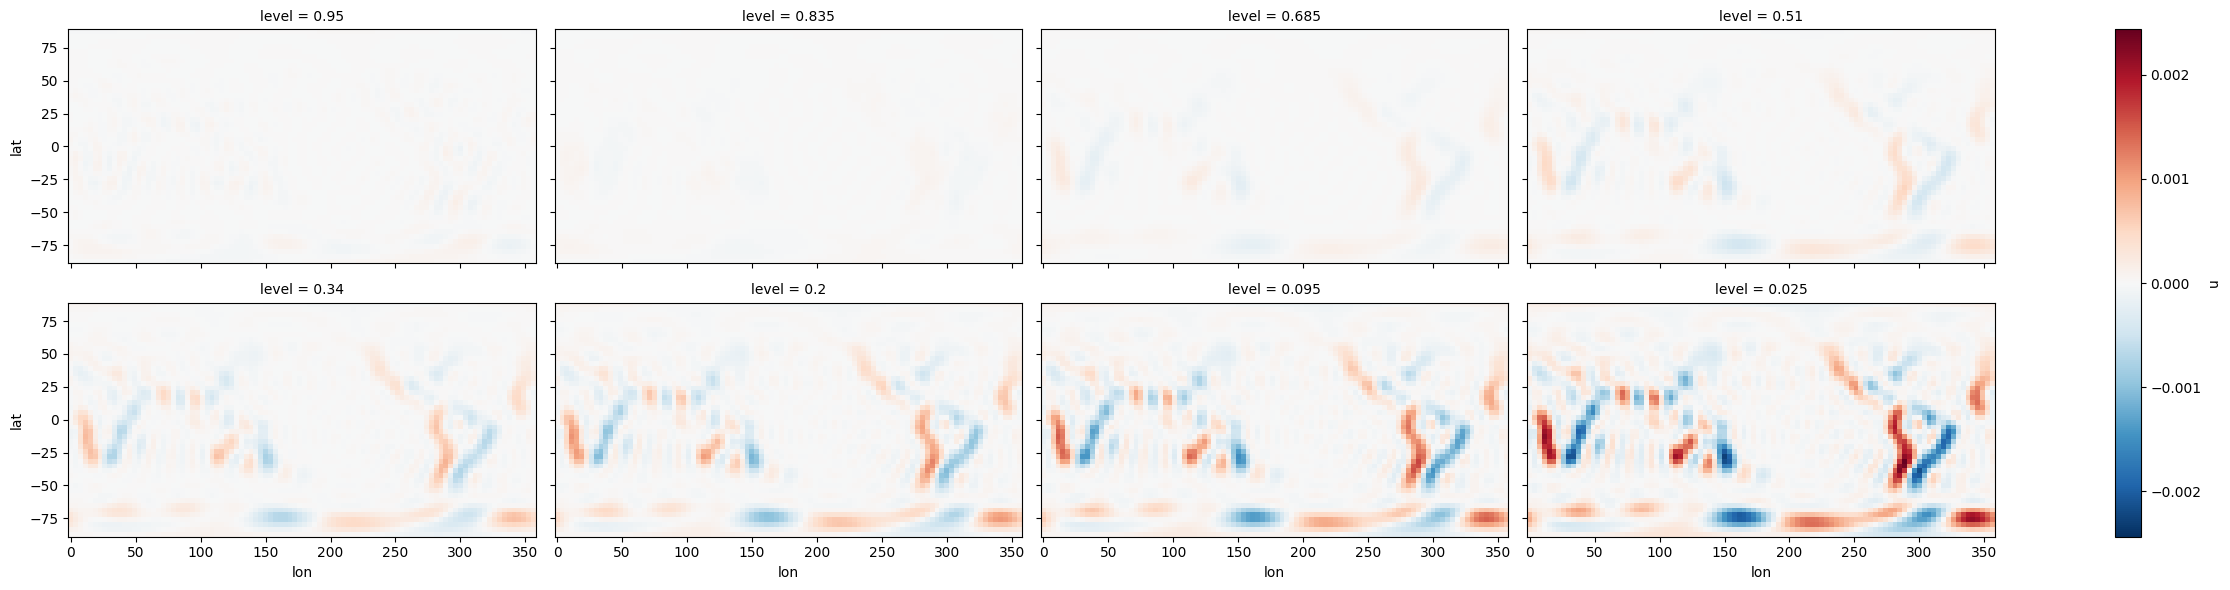

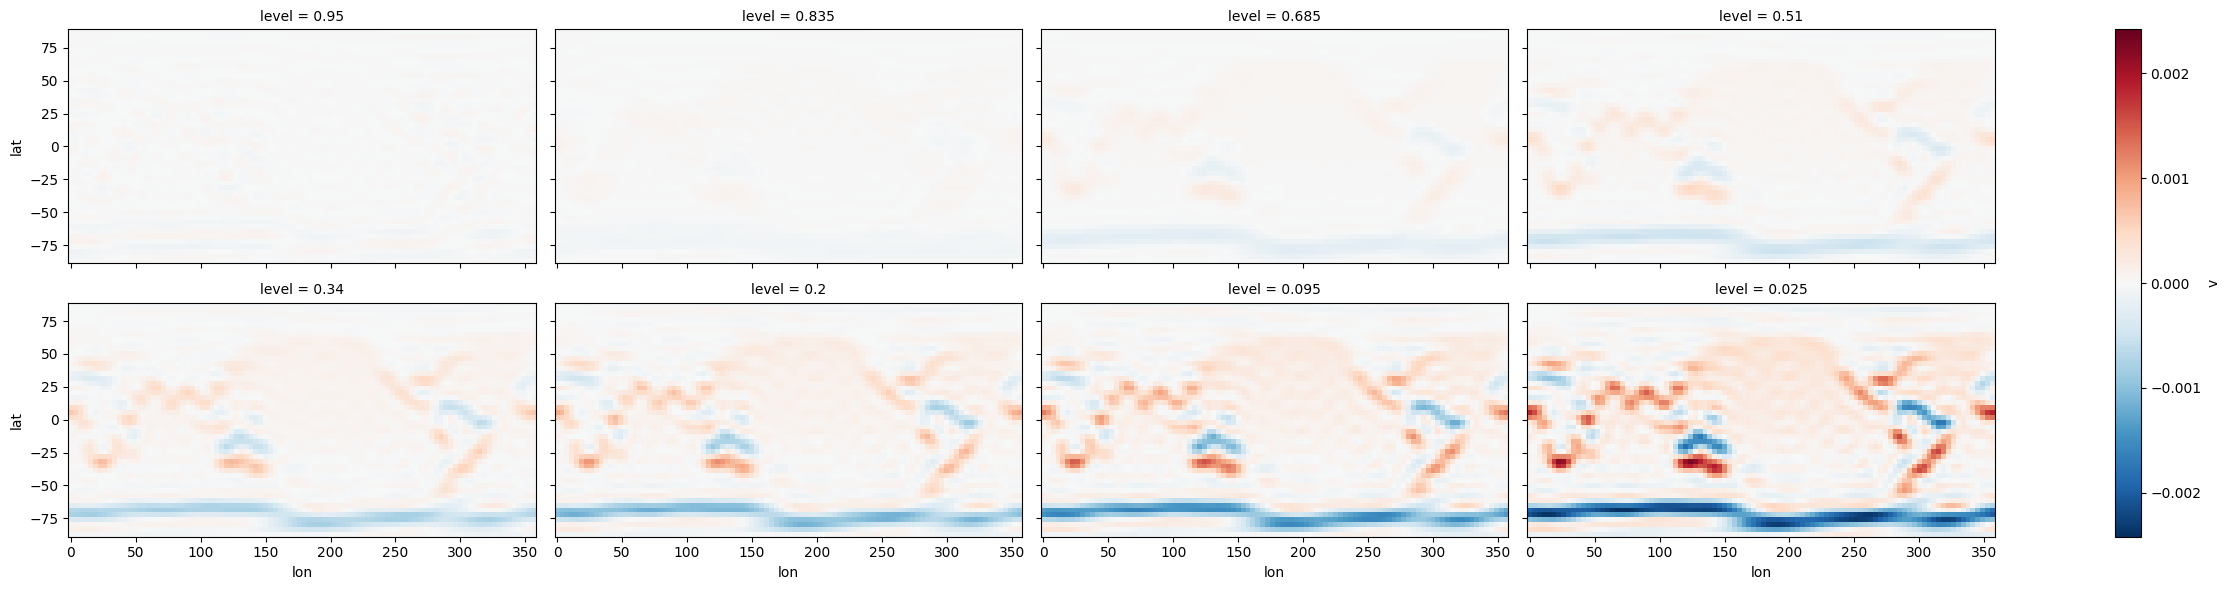

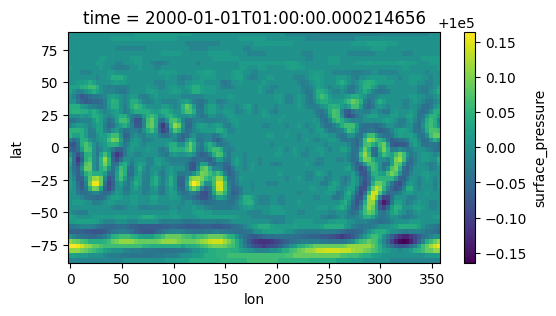

In [ ]:
for v in list(grad_ds.variables):
    if v in ['mod_radcon.ablco2', 'convection.iptop', 'shortwave_rad.icltop', 'shortwave_rad.compute_shortwave',
             'date.model_year', 'date.tyear', 'date.model_step', 'lon', 'lat', 'level', 'time']:
        continue
    data = grad_ds[v].isel(time=1)
    if np.nanmax(data) == np.nanmin(data):
        print(f"gradient of {v} is {np.nanmax(data)}")
        continue
    # data = np.log(np.abs(data))
    if 'level' in grad_ds[v].coords:
        data.plot(x='lon', y='lat', size=3, aspect=2, col='level', col_wrap=4)
    else:
        data.plot(x='lon', y='lat', size=3, aspect=2)